# Illustrative Example for 53 Locations for *Bayesian Network-Informed Conditional Random Forests*

This notebook is an illustrative example using 53 stations, accompanying the article **Bayesian Network-Informed Conditional Random Forests for Probabilistic Multisite Downscaling of Precipitation Occurrence**, submitted to *Environmental Modelling and Software*. It is provided alongside the notebook *BNICRF - Worked Example and Reproducibility of Results.ipynb*, where we explain the basics. This notebook also serves to provide a rough approximation of the computation times required to run the models with bigger datasets. The files `data/data.spatial53.rda` and `data/y.test.spatial53.rda` are provided, with the data already split into a 5-fold cross-validation scheme. This notebook does not employ the predefined functions from *BNICRF - Worked Example and Reproducibility of Results.ipynb*, in order to measure the time required by each step of the process: building the Bayesian network, building the conditional random forest (CRF) ensemble, producing the conditional probability distributions and simulating from them. A final section validates that both the predictive and spatial (multi-site) performance are in line with the results shown in the article mentioned before. 

This notebook was run on an Intel(R) Core(TM) i5-8500 CPU @ 3.00GHz, using parallelization with all the available cores (6) at two critical steps: building each CRF (the trees are built in parallel) and producing the final simulations. Although more efficient parallelization schemes can be devised (such as parallelizing at a higher level, i.e., building the CRF ensemble in parallel), these two processes are by nature highly parallelizable. The highest computational cost is in the construction of the CRF ensemble. Each CRF requires around [0.85-0.93] minutes, and thus the whole ensemble requires around 45 minutes. 

With this configuration and processor, running this notebook takes less than 5 hours.

### Loading Required Packages, Functions and Datasets

In [1]:
set.seed(0)
time_global = Sys.time()

library(BNWeatherGen)
library(RandomForestDist)
library(future.apply)
source("R/sortStationsAncestral.R")
load("data/data.spatial53.rda") # data
load("data/y.test.spatial53.rda") # y.test

Loading required package: bnlearn

Loading required package: gRain

Loading required package: gRbase


Attaching package: ‘gRbase’


The following objects are masked from ‘package:bnlearn’:

    ancestors, children, nodes, parents


Loading required package: pbapply

Loading required package: rpart

Loading required package: progressr

Loading required package: future



### Model Configuration:

In [2]:
maxp <- 4                          # Maximum number of parents
mtry.factor <- 0.33                # This is the proportion of predictors to be used in each split
non.informative.threshold <- 3     # Sample sizes (for conditional distributions) below 3 will use the marginal
non.informative.p <- "marginals" 
ntree <- 100                       # Number of trees per CRF
minbucket <- 15                    # Minimum number of elements per leaf
tabu.list.length = 10^4            # Tabu list length for the Bayesian network structure learning algorithm

`data` is already provided split into the 53 stations and the $5$ sequential folds (1979-1984, 1985-1990, 1991-1996, 1997-2002, 2003-2008).

We now iterate over the 5 folds and the locations to build the BNICRF ensemble, and save the computing time for each part. We also produce the out-of-sample conditional probabilities.

In [3]:
plan(multicore, workers = parallelly::availableCores) # Will use all the available cores in the system


timeToRun <- matrix(NA, nrow = 5, ncol = 3, 
                   dimnames = list(c(names(data$st_4007)),
                                c("BN Graph Construction", "CRF Ensemble Training and Prediction", "Simulation"))
                   ) 


predS <-
  # future_lapply(future.stdout = T, future.seed = TRUE,
                lapply(
                X = names(data$st_4007), # Iterate through folds
                FUN =  function(ifold){
                  
                  message(paste0( "Fold ", ifold, ": "))

                  # Prepare the data for the BN:
                  dataFortheBN = do.call(cbind, lapply(data, function(stdata_) stdata_[[ifold]]$y.train))
                  
                  dataFortheBN <-
                    data.frame(
                      lapply(1:ncol(dataFortheBN),
                             function(icl) {
                               cl <- dataFortheBN[,icl]
                               as.factor(as.character(as.numeric(cl > 1)))
                             }
                      )
                    )
                  
                  colnames(dataFortheBN) = names(data)
                  
                  t0 = Sys.time()
                  
                  # Build the BN:                                         
                  descbn <- buildDescriptive(y = list(Data = dataFortheBN, 
                                                      xyCoords = y.test$xyCoords, 
                                                      Metadata = y.test$Metadata),
                                             structure.learning.algorithm = "tabu",
                                             param.learning.method = "mle",
                                             structure.learning.args.list = list(maxp = maxp, tabu = tabu.list.length)
                  )                                    
                  
                  # And get the ancestral order:
                  ancestral.order <- sortStationsAncestral(descbn, merge.first.block = T, first.alone = T)
                  
                  timeToRun[ifold, "BN Graph Construction"] <<- Sys.time() - t0
                  message(paste0("Elapsed time: ", timeToRun[ifold, "BN Graph Construction"]))
                  
                  
                  rm(descbn)
                  rm(dataFortheBN)
                  gc(full = TRUE)
                  
                  t0 = Sys.time()
                                                       
                  message(paste0("   Building CRF ensemble and predicting ..."))

                  
                  for (stid in names(ancestral.order)){ # Build the CRF ensemble
                    if (stid == names(ancestral.order)[1]){ # The first CRF is just a standard RF
                      
                      full.data <- data[[paste("st", ancestral.order[[stid]], sep = "_")]]
                      md1 <- randomForestTrain(x = full.data[[ifold]]$x.train,
                                               y = as.numeric(full.data[[ifold]]$y.train > 1), 
                                               method = "binaryCrossEntropy",
                                               ntree = ntree, 
                                               minbucket = minbucket, 
                                               progress.bar = F, 
                                               parallel.plan = NULL)
                      pr1 <- randomForestPredict(md1, full.data[[ifold]]$x.test,
                                                 bagging.function = mean)
                      md1 <- NULL
                      rm(md1)
                      gc(full = TRUE)
                      
                    } else { # And the rest are "true" CRFs:
  
                      full.data <- lapply(paste("st", ancestral.order[[stid]], sep = "_"),
                                          function(iiist) return(data[[iiist]]))
                      
                      x.train <- do.call(cbind,
                                         lapply(full.data, function(iiist) iiist[[ifold]]$x.train))
                      y.train <- do.call(cbind,
                                         lapply(full.data, function(iiist) iiist[[ifold]]$y.train))
                      x.test <- do.call(cbind,
                                        lapply(full.data, function(iiist) iiist[[ifold]]$x.test))
                      
                      #remove duplicates in x.train
                      
                      unique.columns <- 1
                      if (!identical(x.test[,2], x.test[,1])) unique.columns <- c(unique.columns, 2)
                      for (ic in 3:ncol(x.test)){
                        identicS <-
                          apply(x.test[, 1:(ic-1) ], MARGIN = 2, FUN = function(cc){
                            return( identical(cc, x.test[, ic]) )
                          })
                        
                        if (sum(identicS) ==  0) unique.columns <- c(unique.columns, ic)
                      }
                      
                      x.train <- x.train[, unique.columns]
                      x.test <- x.test[, unique.columns]
                      
                      # binary
                      y.train <- matrix(as.numeric(y.train > 1),
                                        ncol = ncol(y.train) )
                      
                      
                      mtry <- floor(ncol(x.train)*mtry.factor)
                      
                      md <- randomForestTrain(x = x.train,
                                              y = y.train,
                                              minbucket = minbucket,
                                              minsplit = 2*minbucket,
                                              mtry = mtry,
                                              ntree = ntree,
                                              method = "binaryMultiEntropyCond"
                                              ,parallel.plan = NULL,                                              
                                              progress.bar = F,
                                              resample = T,
                                              replace = F,
                                              sampsize = floor(0.632*nrow(x.train)), 
                                              undersample.binary = F
                      )
                                            
                      if (stid == names(ancestral.order)[2]){
                        pred.ap <-
                          randomForestPredict(md, newdata = x.test
                                              , method = "aposteriori",
                                              non.informative.threshold = non.informative.threshold,
                                              non.informative.p = non.informative.p)
                        
                        pred.ap[,1] <- pr1
                      } else {
                        aux <-
                          randomForestPredict(md, newdata = x.test
                                              , method = "aposteriori",
                                              non.informative.threshold = non.informative.threshold,
                                              non.informative.p = non.informative.p)
                        
                        aux <- aux[ ,
                                    ncol(aux) - seq(from = 2^(length(ancestral.order[[stid]])-1)-1, to = 0, by = -1)]
                        pred.ap <- cbind(pred.ap, aux)
                      }
                      
                      md <- NULL
                      rm(md)
                      gc(full = TRUE)
                      
                    }
                  }
                  
                  attr(pred.ap, "ancestral.order") <- ancestral.order
                  
                  timeToRun[ifold, "CRF Ensemble Training and Prediction"] <<- Sys.time() - t0
                  message(paste0("Done. Elapsed time: ", timeToRun[ifold, "CRF Ensemble Training and Prediction"],
                                ". Average time per CRF: ",
                        timeToRun[ifold, "CRF Ensemble Training and Prediction"]/length(ancestral.order)))
                  
                  return( pred.ap )
                })

names(predS) <- names(data$st_4007)
                                        
plan(sequential)

Fold f1_79_84: 



[1] "Building Bayesian Network using tabu..."
[1] "Done building Bayesian Network."


Elapsed time: 2.11281280517578

   Building CRF ensemble and predicting ...

Done. Elapsed time: 43.4455196936925. Average time per CRF: 0.851872935170442

Fold f2_85_90: 



[1] "Building Bayesian Network using tabu..."
[1] "Done building Bayesian Network."


Elapsed time: 2.95561732053757

   Building CRF ensemble and predicting ...

Done. Elapsed time: 44.7673272053401. Average time per CRF: 0.877790729516472

Fold f3_91_96: 



[1] "Building Bayesian Network using tabu..."
[1] "Done building Bayesian Network."


Elapsed time: 3.0076496720314

   Building CRF ensemble and predicting ...

Done. Elapsed time: 43.4590153972308. Average time per CRF: 0.852137556808447

Fold f4_97_02: 



[1] "Building Bayesian Network using tabu..."
[1] "Done building Bayesian Network."


Elapsed time: 2.19092486302058

   Building CRF ensemble and predicting ...

Done. Elapsed time: 44.398747253418. Average time per CRF: 0.870563671635646

Fold f5_03_08: 



[1] "Building Bayesian Network using tabu..."
[1] "Done building Bayesian Network."


Elapsed time: 5.01194048722585

   Building CRF ensemble and predicting ...

Done. Elapsed time: 47.3138853033384. Average time per CRF: 0.927723241241929



### Simulation of 250 samples

We now proceed to simulate from the predicted probabilities:

In [4]:
plan(multicore, workers = parallelly::availableCores)

completeSimulations <-
  lapply(X = names(predS),  FUN =  function(ifold){
    
    message(paste0( "Simulating for fold ", ifold, "..."))

    t0 = Sys.time()
      
    ancestral.order = attr(predS[[ifold]], "ancestral.order")  
    ancestral.order.withoutfirst <- ancestral.order[2:length(ancestral.order)]
    
    simS <-
      future_lapply( future.seed = T,
                     X = 1:250, function(nsim){
                       for (nodeindex in 1:length(ancestral.order.withoutfirst)){
                         if (nodeindex == 1){
                           common.idx <- sum(2^seq(0, to = length(ancestral.order.withoutfirst[[1]])-1, by = 1))
                           prmat <- predS[[ifold]][, 1:common.idx]
                           class(prmat) <- "RandomForestDist.prediction.simulable"
                           sim <- randomForestSimulate(prmat, distr = "conditionalBernoulli", n = 1)[,,1]
                           colnames(sim) <- ancestral.order.withoutfirst[[1]]
                         } else {
                           current.nodes <- ancestral.order.withoutfirst[[nodeindex]][1:(length(ancestral.order.withoutfirst[[nodeindex]])-1)]
                           ids.cond <- match(current.nodes, colnames(sim))
                           aux.sim <- sim[, ids.cond]
                           
                           prmat.idx <- seq((common.idx + 1), by = 1, length.out = 2^(length(ancestral.order.withoutfirst[[nodeindex]])-1))
                           common.idx <- max(prmat.idx)
                           
                           aux.prmat <- predS[[ifold]][, prmat.idx]
                           
                           cn <- colnames(sim)
                           sim <- cbind(sim,
                                        sapply(X = 1:nrow(aux.sim), FUN = function(ipr){
                                          ss <- aux.sim[ipr,]
                                          p <- aux.prmat[ipr, sum( sapply(1:length(ss), function(ik) ss[ik]*2^(ik-1) ) )+1]
                                          sample(c(0,1), size = 1, prob = c(1-p, p))
                                        })
                           )
                           
                           colnames(sim) <- c(cn, ancestral.order.withoutfirst[[nodeindex]][length(ancestral.order.withoutfirst[[nodeindex]])])
                         }
                       }
    
                      sim = sim[, match(y.test$Metadata$station_id, colnames(sim))]
                       
                      return(sim)
                     })
    
    timeToRun[ifold, "Simulation"] <<- Sys.time() - t0
    message("Done.")
    message(paste0("Elapsed time: ", timeToRun[ifold, "Simulation"]))
    
    return(simS)
  })
                                                         
plan(sequential)


# Rearange simulations for validation:
completeSimulations <-
  lapply(1:250, function(simi){
    do.call(rbind,
            lapply(completeSimulations, function(simii){
              simii[[simi]]
            })
    )
  })

Simulating for fold f1_79_84...

Done.

Elapsed time: 1.90909519195557

Simulating for fold f2_85_90...

Done.

Elapsed time: 2.22113316059113

Simulating for fold f3_91_96...

Done.

Elapsed time: 2.35605706771215

Simulating for fold f4_97_02...

Done.

Elapsed time: 1.92131596008937

Simulating for fold f5_03_08...

Done.

Elapsed time: 1.49155206282934



### Total Elapsed Time (in minutes):

In [5]:
timeToRun

,BN Graph Construction,CRF Ensemble Training and Prediction,Simulation
f1_79_84,2.112813,43.44552,1.909095
f2_85_90,2.955617,44.76733,2.221133
f3_91_96,3.007650,43.45902,2.356057
f4_97_02,2.190925,44.39875,1.921316
f5_03_08,5.011940,47.31389,1.491552


This was run on an Intel(R) Core(TM) i5-8500 CPU @ 3.00GHz. Total time required to run the notebook:

In [6]:
time_global = Sys.time() - time_global
print(time_global)

Time difference of 4.147089 hours


### Validation of Spatial Correlation and AUC:

In [7]:
y.test.bin <-
        do.call(cbind,
          lapply(1:ncol(y.test$Data),
                 function(icl) {
                   cl <- y.test$Data[,icl]
                   as.factor(cl > 1)
                 }
          )
        )
names(y.test.bin) = y.test$Metadata$station_id

spatial_correlation <- 
  apply(simplify2array(
    lapply(completeSimulations,
           function(sim) cor(sim))
    ), MARGIN = c(1,2), mean)

    
marginals <- apply(simplify2array(completeSimulations), MARGIN = c(1,2), mean)
AUC <-
  sapply(1:ncol(marginals), function(icol){
    auc <- sapply(ROCR::performance(
      ROCR::prediction(marginals[, icol], y.test.bin[, icol])
      ,"auc")@y.values, function(x) x)
    auc
  })
      
AUC    

[1] 0.8865368 0.8675661 0.8460418 0.8393579 0.8619715 0.8517004 0.8352027
 [8] 0.8680235 0.8577513 0.8800570 0.8839056 0.8347798 0.8559454 0.8501942
[15] 0.8606698 0.8858612 0.8479624 0.8543684 0.8543676 0.8656196 0.8335783
[22] 0.8468526 0.8481575 0.8527706 0.8764046 0.8453033 0.8414853 0.8638041
[29] 0.8307466 0.8424544 0.8485922 0.8470766 0.8623849 0.8631202 0.8571540
[36] 0.8426360 0.8479786 0.8305114 0.8397298 0.8601109 0.8507836 0.8356690
[43] 0.8455845 0.8605801 0.8492494 0.7680580 0.8395006 0.8488904 0.8541257
[50] 0.8351631 0.8589060 0.8823001 0.8808798

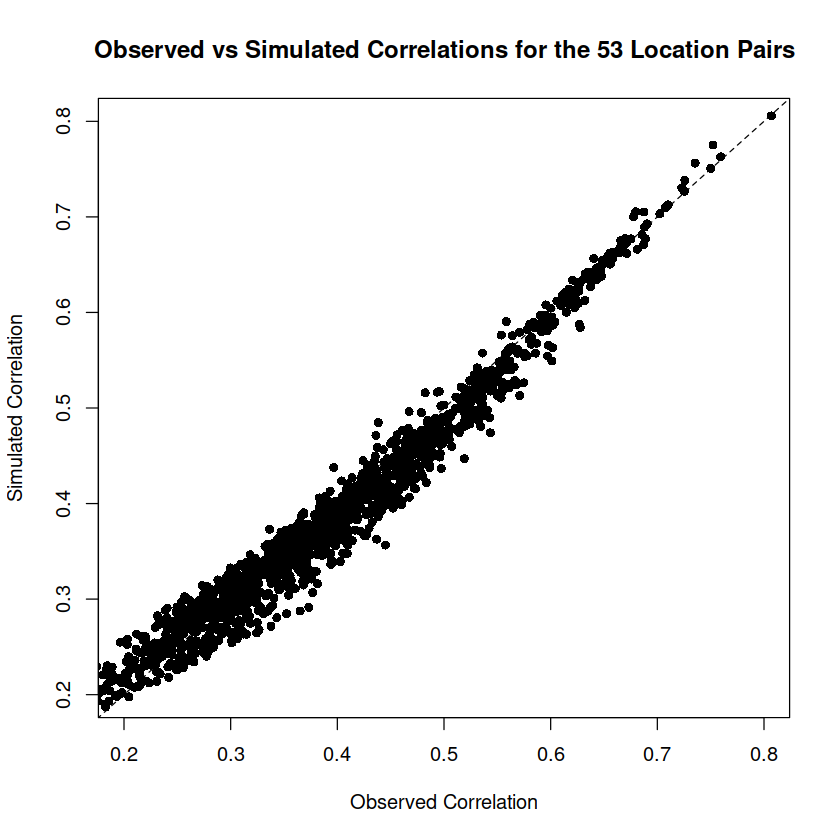

In [8]:
plot(cor(y.test.bin), spatial_correlation, xlab = "Observed Correlation", ylab = "Simulated Correlation", 
     xlim = c(0.2,0.8),
     ylim = c(0.2,0.8),
     pch = 16,
     main = "Observed vs Simulated Correlations for the 53 Location Pairs")
lines(seq(0,1), seq(0,1), lty = "dashed")